In [1]:
%pip install --upgrade pip
%pip install torch
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import optuna
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [35]:
# Load data
# Example: Assuming you have a CSV file with 'date' and 'layoffs' columns
data = pd.read_csv('/Users/asaifali/Desktop/Ravuru_Tech_Pvt_Ltd/Assignment 2/layoffs_1.csv')#,index_col=5, parse_dates=True)
data

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Edgio,Phoenix,Infrastructure,NaN,1.00,2024-09-09,Post-IPO,United States,529.0
1,InsurStaq.ai,New Delhi,AI,NaN,1.00,2024-09-09,Seed,India,NaN
2,Nori,Seattle,Energy,NaN,1.00,2024-09-09,Unknown,United States,19.0
3,WeTransfer,Amsterdam,Other,260.0,0.75,2024-09-08,Acquired,Netherlands,64.0
4,Goop,Los Angeles,Retail,39.0,0.18,2024-09-06,Unknown,United States,75.0
...,...,...,...,...,...,...,...,...,...
3782,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1
3783,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0
3784,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0
3785,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0


In [36]:
data.isnull().sum()

company                   0
location                  1
industry                  1
total_laid_off         1313
percentage_laid_off    1358
date                      0
stage                     7
country                   0
funds_raised            409
dtype: int64

In [37]:
data.dropna(subset=['location'], inplace=True)
data.dropna(subset=['industry'], inplace=True)
data.dropna(subset=['total_laid_off'], inplace=True)
data.dropna(subset=['percentage_laid_off'], inplace=True)
data.dropna(subset=['stage'], inplace=True)
data.dropna(subset=['funds_raised'], inplace=True)

In [38]:
data.isnull().sum()

company                0
location               0
industry               0
total_laid_off         0
percentage_laid_off    0
date                   0
stage                  0
country                0
funds_raised           0
dtype: int64

In [39]:
# Label Encoding
label_encoder = LabelEncoder()
data = data.copy()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

print("Label Encoded Data:")
print(data)


Label Encoded Data:
      company  location  industry  total_laid_off  percentage_laid_off  date  \
3        1157         1        20           260.0                 0.75   620   
4         443        68        24            39.0                 0.18   619   
6         200       106        17           250.0                 0.15   618   
7         640       106        28            30.0                 0.01   618   
11        313        12        10           150.0                 0.75   617   
...       ...       ...       ...             ...                  ...   ...   
3780      526        35        29           130.0                 0.22     2   
3781      473         5        27            16.0                 1.00     2   
3783      486        68        28             8.0                 0.10     1   
3784      769       106         3             6.0                 0.75     1   
3785     1018        68        24            20.0                 0.40     0   

      stage  countr

total length: 1573
time frequency: 1.0


<Axes: >

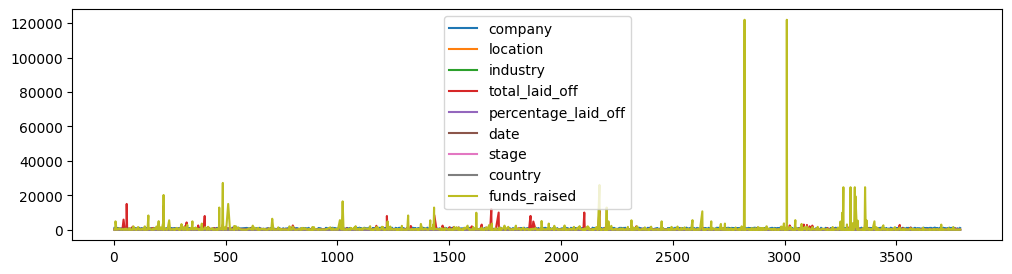

In [40]:
print(f"total length: {data.shape[0]}")
print(f"time frequency: {data.index.diff()[1]}")
data.plot(figsize=(12, 3))

In [41]:
#Define the target variable
target_variable = 'total_laid_off'

# Define the exogenous variables
exogenous_variables = data.drop('total_laid_off', axis=1).columns.tolist()
# Combine the target variable and exogenous variables into one DataFrame
data_selected = data[[target_variable] + exogenous_variables]
#data_selected = data[['Laid_Off_Count', 'Date']]
# Handle missing values
data_selected.dropna(axis=0, inplace=True)

# Split the data into training and testing sets
train_size = int(len(data_selected) * 0.8)  # 80% train, 20% test
train_data, test_data = data_selected.iloc[:train_size], data_selected.iloc[train_size:]

# Extract features (exogenous variables) and target variable for training and testing sets
X_train = train_data[exogenous_variables].values
y_train = train_data[target_variable].values
X_test = test_data[exogenous_variables].values
y_test = test_data[target_variable].values

In [50]:
# Function to create sequences of lagged data
def create_sequences(data, target, lag):
    sequences = []
    targets = []
    for i in range(lag, len(data)):
        seq = data[i - lag:i]  # Sequence of 'lag' time steps
        sequences.append(seq)
        targets.append(target[i])  # The target is the current step after the lag
    return np.array(sequences), np.array(targets)

# Create sequences from the training and test data
lag = 3  # Number of previous time steps to consider
X_train_seq, y_train_seq = create_sequences(X_train, train_data[target_variable].values, lag)
X_test_seq, y_test_seq = create_sequences(X_test, test_data[target_variable].values, lag)

# Check the shape of the sequences
print(f"X_train_seq shape: {X_train_seq.shape}")  # Should be (num_samples, lag, num_features)
print(f"y_train_seq shape: {y_train_seq.shape}")  # Should be (num_samples,)


X_train_seq shape: (1253, 3, 11)
y_train_seq shape: (1253,)


In [49]:
# Check the shape of the sequences
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")

X_train_seq shape: (1253, 3, 11)
y_train_seq shape: (1253, 11)


In [43]:
# Split the data into training and testing sets
train_size = int(len(data_lagged) * 0.8)
train_data, test_data = data_lagged.iloc[:train_size], data_lagged.iloc[train_size:]
# Extract features (including lagged features) and target variable
X_train = train_data.drop(target_variable, axis=1).values
y_train = train_data[target_variable].values
X_test = test_data.drop(target_variable, axis=1).values
y_test = test_data[target_variable].values


In [44]:
# Normalize features and target
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

In [45]:
# Reshape X_train and X_test to have a sequence length of `lag`
X_train_reshaped = X_train.reshape((X_train.shape[0], lag, X_train.shape[1] // lag))
X_test_reshaped = X_test.reshape((X_test.shape[0], lag, X_test.shape[1] // lag))


ValueError: cannot reshape array of size 13816 into shape (1256,3,3)

In [46]:
# Convert to tensors
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# Convert to tensors for training
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)


In [27]:
# Define the XLSTM model with improved architecture
class XLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob=0.5):
        super(XLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        # Apply batch normalization (after LSTM, before fully connected layer)
        out = self.batch_norm(out[:, -1, :])

        # Apply dropout
        out = self.dropout(out)

        # Final fully connected layer
        out = self.fc(out)

        return out

In [28]:
# Optuna study for hyperparameter tuning
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    dropout_prob = trial.suggest_uniform('dropout_prob', 0.2, 0.7)
    epochs = 50  # Number of epochs

    # Initialize model with trial hyperparameters
    input_size = X_train_reshaped.shape[2]
    model = XLSTM(input_size, hidden_size, 1, num_layers, dropout_prob).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)


In [29]:
# Perform Optuna tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Increase the number of trials for better results

# Get the best hyperparameters
best_params = study.best_params
best_hidden_size = best_params['hidden_size']
best_num_layers = best_params['num_layers']
best_dropout = best_params['dropout_prob']
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']
best_weight_decay = best_params['weight_decay']
print("Best MSE:", study.best_value)


[I 2024-09-20 10:51:10,223] A new study created in memory with name: no-name-4519f2e7-bc82-4448-aee2-9b60be21a8e1
/var/folders/89/zwv576xj2cggljymv3ln02780000gn/T/ipykernel_5924/415832506.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/Users/asaifali/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2763318322106867 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-09-20 10:51:34,459] Trial 0 finished with value: 0.00104419249315682 and parameters: {'hidden_size': 65, 'num_layers': 1, 'dropout_prob': 0.2763318322106867, 'lr': 0.008860595647393108, 'batch_s

Best MSE: 0.0006039419203543929


/Users/asaifali/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2258826600106054 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/100], Loss: 0.1682, Test Loss: 0.0010
Epoch [2/100], Loss: 0.1102, Test Loss: 0.0012
Epoch [3/100], Loss: 0.1054, Test Loss: 0.0008
Epoch [4/100], Loss: 0.0989, Test Loss: 0.0007
Epoch [5/100], Loss: 0.0854, Test Loss: 0.0009
Epoch [6/100], Loss: 0.0829, Test Loss: 0.0010
Epoch [7/100], Loss: 0.0707, Test Loss: 0.0016
Epoch [8/100], Loss: 0.0777, Test Loss: 0.0042
Epoch [9/100], Loss: 0.0675, Test Loss: 0.0038
Epoch [10/100], Loss: 0.0714, Test Loss: 0.0026
Epoch [11/100], Loss: 0.0629, Test Loss: 0.0025
Epoch [12/100], Loss: 0.0613, Test Loss: 0.0020
Epoch [13/100], Loss: 0.0563, Test Loss: 0.0032
Epoch [14/100], Loss: 0.0537, Test Loss: 0.0027
Early stopping triggered!
Test Loss: 0.0027


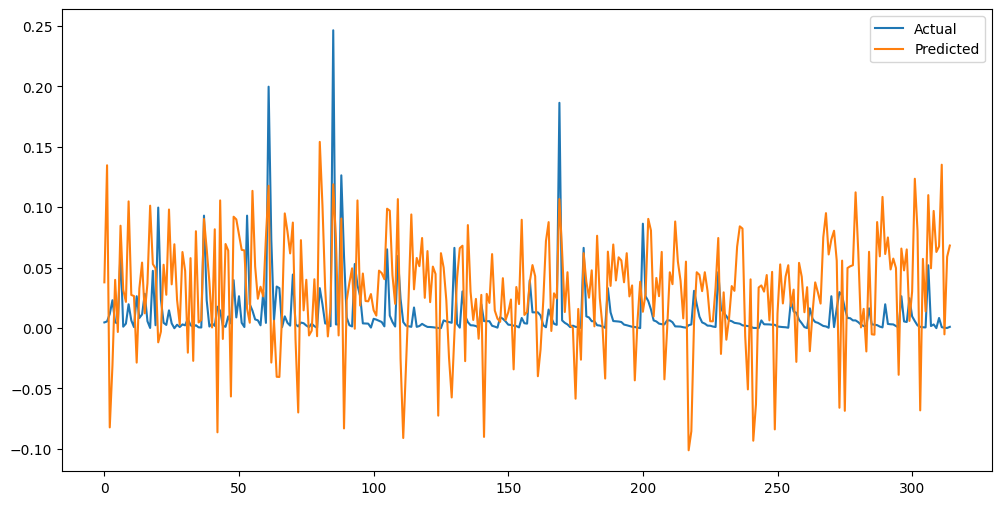

In [30]:
# Train the model with the best parameters
hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
lr = best_params['lr']
batch_size = best_params['batch_size']
dropout_prob = best_params['dropout_prob']
epochs = 50

# Final model training
model = XLSTM(X_train_reshaped.shape[2], hidden_size, 1, num_layers, dropout_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform predictions
test_predictions_inversed = y_scaler.inverse_transform(test_predictions.cpu().numpy().reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1)), label='Actual')
plt.plot(test_predictions_inversed, label='Predicted')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming y_test_tensor contains the true labels and model_outputs contains the predictions from the model
# Reshape y_test to match the shape of model outputs
# Ensure both arrays have the same length for comparison (use only the relevant part of y_test)
y_test_reshaped = y_test_tensor.cpu().numpy().reshape(-1)[:len(test_predictions)]
model_outputs_reshaped = test_predictions.cpu().numpy().reshape(-1)  # Reshape model outputs if necessary

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_reshaped, model_outputs_reshaped)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_reshaped, model_outputs_reshaped)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R^2) score
r2 = r2_score(y_test_reshaped, model_outputs_reshaped)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2) Score:", r2)


Mean Squared Error (MSE): 0.0026789275
Mean Absolute Error (MAE): 0.042617287
Root Mean Squared Error (RMSE): 0.051758356
R-squared (R^2) Score: -2.927304983139038


Future Predictions: [1028.79475478 -395.07866781 1477.36288067 1393.45582176  862.54250292
  717.66926888  932.58984488  822.29283739  850.3965931   755.67400347
  811.38133794  818.36191796  816.48600299  800.88231411  804.30981666
  804.4906937   808.18576913  804.6323565   805.14873307  805.06695297
  805.76655272  805.31631526  805.28123472  805.18470738  805.37966132
  805.31888485  805.31329878  805.27497832  805.30156802  805.30760098]


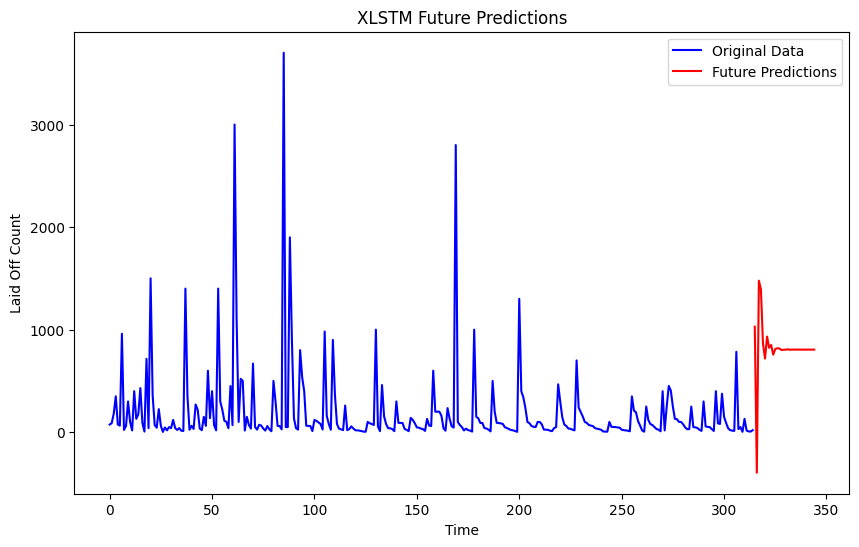

In [32]:
# Future predictions as before
def predict_future(model, last_sequence, future_steps, device, input_size):
    model.eval()
    predictions = []
    current_seq = last_sequence.clone().detach().to(device)
    
    for _ in range(future_steps):
        with torch.no_grad():
            current_seq_reshaped = current_seq.unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, input_size)
            prediction = model(current_seq_reshaped)
            predictions.append(prediction.item())
            prediction = torch.tensor([prediction.item()], dtype=torch.float32).to(device)
            current_seq = torch.cat([current_seq[1:], prediction], dim=0)
    
    return predictions


# Generate future predictions
future_steps = 30
last_sequence = torch.tensor(X_test[-1], dtype=torch.float32).to(device)  # Last input sequence from the test set

# Predict future values using the updated function
future_predictions = predict_future(model, last_sequence, future_steps, device, input_size=X_test.shape[1])

# Inverse transform the predictions (if necessary)
future_predictions = y_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Print the future predictions
print(f"Future Predictions: {future_predictions}")

# Plot the future predictions alongside the original data
plt.figure(figsize=(10, 6))

# Plot the original test data (inverse transformed if it was scaled)
original_data = y_scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# Plot the original test data
plt.plot(np.arange(len(original_data)), original_data, label='Original Data', color='blue')

# Plot the future predictions
plt.plot(np.arange(len(original_data), len(original_data) + future_steps), future_predictions, label='Future Predictions', color='red')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Laid Off Count')
plt.title('XLSTM Future Predictions')
plt.legend()

# Show the plot
plt.show()


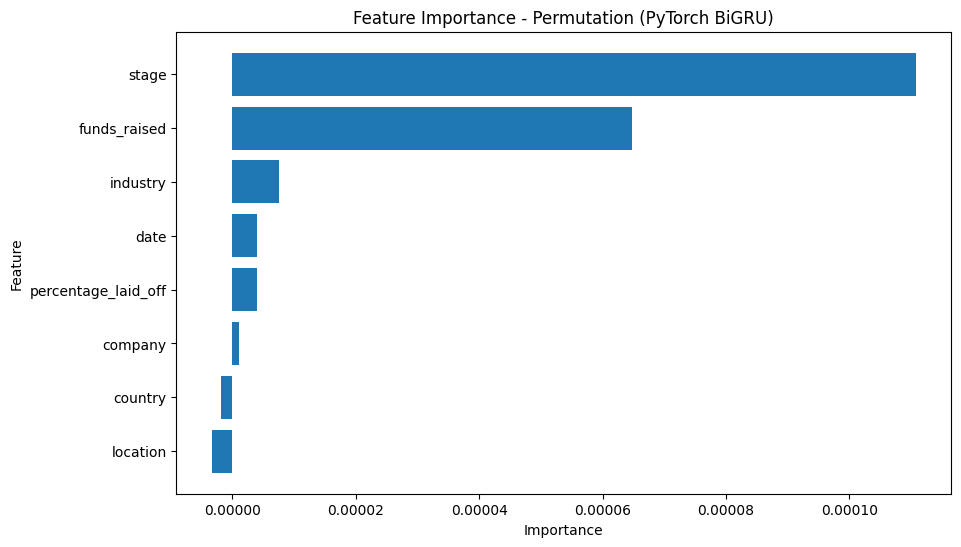

               Feature  Importance
5                stage    0.000111
7         funds_raised    0.000065
2             industry    0.000008
4                 date    0.000004
3  percentage_laid_off    0.000004
0              company    0.000001
6              country   -0.000002
1             location   -0.000003


In [22]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Assuming the sequence length is 1
sequence_length = 1

# Reshape X_test to include sequence length
X_test_reshaped = X_test.reshape((X_test.shape[0], sequence_length, X_test.shape[1]))

# Convert to tensor
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32).to(device)


def custom_permutation_importance(model, X_test, y_test, n_repeats=10):
    """
    Calculate permutation importance for a PyTorch model.

    Parameters:
    - model: Trained PyTorch model.
    - X_test: Test dataset (NumPy array).
    - y_test: True values (NumPy array).
    - n_repeats: Number of times to permute each feature.

    Returns:
    - feature_importances: Mean drop in performance for each feature.
    """
    # Get baseline predictions and baseline MSE
    model.eval().to(device)
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Ensure sequence length is included
    X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        baseline_preds = model(X_test_tensor).cpu().numpy()
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    feature_importances = np.zeros(X_test.shape[1])

    # Iterate over each feature
    for col in range(X_test.shape[1]):
        permuted_mse = []
        
        # Repeat the permutation process `n_repeats` times
        for _ in range(n_repeats):
            X_permuted = X_test.copy()
            
            # Permute the column (shuffle the feature)
            np.random.shuffle(X_permuted[:, col])
            
            # Reshape permuted data
            X_permuted_reshaped = X_permuted.reshape((X_permuted.shape[0], 1, X_permuted.shape[1]))
            X_permuted_tensor = torch.tensor(X_permuted_reshaped, dtype=torch.float32).to(device)
            
            # Get model predictions for permuted data
            with torch.no_grad():
                permuted_preds = model(X_permuted_tensor).cpu().numpy()
                
            # Calculate MSE for permuted data
            permuted_mse.append(mean_squared_error(y_test, permuted_preds))
        
        # The importance is the mean increase in MSE compared to the baseline
        feature_importances[col] = np.mean(permuted_mse) - baseline_mse
    
    return feature_importances


# Assuming you have X_test and y_test ready
n_repeats = 100
feature_importances = custom_permutation_importance(model, X_test, y_test, n_repeats)

# Plot feature importances
features = exogenous_variables  # Exogenous variables

importance_df_perm = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df_perm = importance_df_perm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_perm['Feature'], importance_df_perm['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Permutation (PyTorch BiGRU)')
plt.gca().invert_yaxis()
plt.show()

print(importance_df_perm)


In [23]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Define the evaluate_feature_subset function
def evaluate_feature_subset(features_subset):
    # Prepare data
    feature_indices = [exogenous_variables.index(f) for f in features_subset]
    X_train_subset = X_train[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]

    # Normalize the selected features
    scaler = MinMaxScaler()
    X_train_subset = scaler.fit_transform(X_train_subset)
    X_test_subset = scaler.transform(X_test_subset)

    # Reshape data to fit the model
    X_train_reshaped = X_train_subset.reshape((X_train_subset.shape[0], 1, X_train_subset.shape[1]))
    X_test_reshaped = X_test_subset.reshape((X_test_subset.shape[0], 1, X_test_subset.shape[1]))

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Initialize and train the BiGRU model
    model = XLSTM(input_size=len(features_subset), hidden_size=64, output_size=1, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().cpu().numpy()
        mse = mean_squared_error(y_test, predictions)

    return mse

# Perform feature selection
best_mse = float('inf')
best_features = []

# Use tqdm to show progress
for subset_size in tqdm(range(1, len(exogenous_variables) + 1), desc='Feature Selection', unit='subset'):
    for subset in combinations(exogenous_variables, subset_size):
        mse = evaluate_feature_subset(subset)
        if mse < best_mse:
            best_mse = mse
            best_features = [subset]  # Reset to new best subset
        elif mse == best_mse:
            best_features.append(subset)  # Add to list of best subsets

print("Best features:", best_features)
print("Best MSE:", best_mse)


Feature Selection: 100%|██████████| 8/8 [02:21<00:00, 17.63s/subset]

Best features: [('location', 'industry', 'date', 'stage', 'funds_raised')]
Best MSE: 0.0006698269669200514
